Degree | Train MSE | Test MSE | Train R2 | Test R2
  1    | 251.9758 | 219.1388 | 0.8178 | 0.8554
  2    | 110.9038 | 183.0524 | 0.9198 | 0.8792
  3    | 93.7089 | 164.1356 | 0.9322 | 0.8917
  4    | 87.1039 | 148.7908 | 0.9370 | 0.9018
  5    | 86.8656 | 145.4789 | 0.9372 | 0.9040
Best polynomial degree: 5


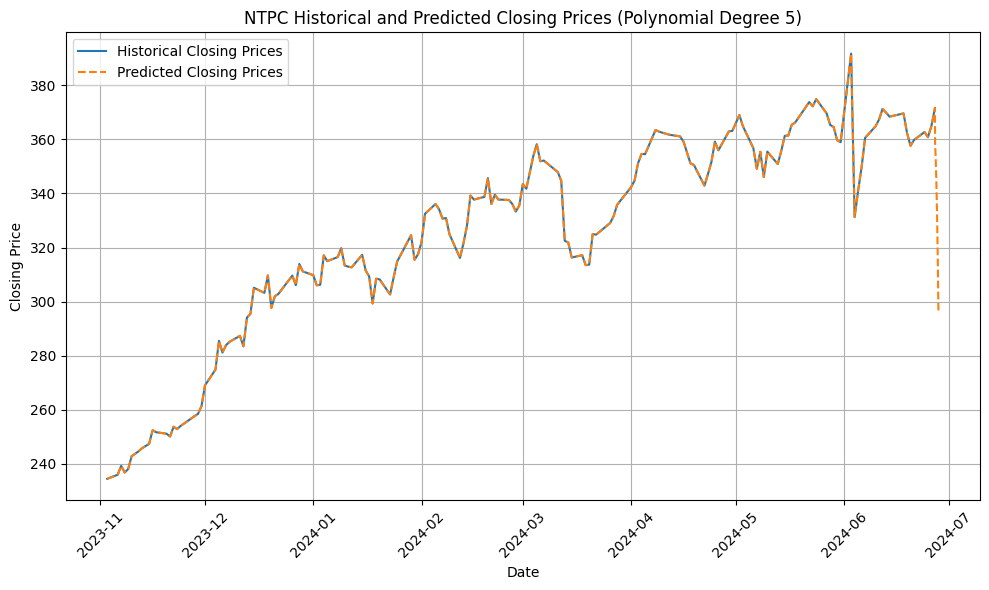

In [26]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import uuid
import yfinance as yf
from datetime import datetime

# Function to check and convert values to float
def convert_to_float(value):
    try:
        if isinstance(value, str):
            return float(value.replace(',', ''))
        else:
            return float(value)
    except ValueError:
        # Handle any non-numeric values gracefully
        return np.nan

def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)   
    #stock_data.reset_index(inplace=True)  # Reset index to get 'Date' as a column
    stock_data.dropna(inplace=True)
    return stock_data

# Regular expression to remove the timezone name in parentheses
def remove_timezone_name(date_str):
    return re.sub(r'\s*\(.*\)$', '', date_str)


folder_path = f'C:/Raghav Proj/StockFinder/YahooCsvFiles'    

#def genarate_png(file_path):
def genarate_png(scriptName, start_date, end_date):
    uid = uuid.uuid4()
    output_file_path = f'C:\\Raghav Proj\\StockFinder\\Output\\{scriptName}_{uid}.png'    

    df = fetch_stock_data(scriptName, start_date, end_date)

    #min_avg_volume = 1000000  # Example: minimum average volume of 1,000,000
    # Get the filtered stocks
    filtered_stocks = filter_stocks_by_volume_and_increase(scriptName, df, start_date, end_date)

    df.reset_index(inplace=True)  # Reset index to get 'Date' as a column
    
    # Ensure the Date column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Apply the conversion function to the 'Close' column
    df['Close'] = df['Close'].apply(convert_to_float)

    # Sort data by date
    df = df.sort_values(by='Date')

    # Extract the 'Date' and 'Close' columns
    dates = df['Date']
    closing_prices = df['Close']

    # Prepare the data for the regression model
    X = np.array(range(len(dates))).reshape(-1, 1)
    y = closing_prices.values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
    # Evaluate polynomial regression models up to degree 7
    max_degree = 7
    results = evaluate_polynomial_regression(X_train, y_train, X_test, y_test, max_degree)

    # Print the results
    print("Degree | Train MSE | Test MSE | Train R2 | Test R2")
    for degree, train_mse, test_mse, train_r2, test_r2 in results:
        print(f"{degree:^6} | {train_mse:.4f} | {test_mse:.4f} | {train_r2:.4f} | {test_r2:.4f}")

    # Select the best degree based on the test MSE or R2
    best_degree = min(results, key=lambda x: x[2])[0]  # Select based on test MSE

    print(f"Best polynomial degree: {best_degree}")

    # Fit and predict with the best degree
    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict future values
    future_days = 5
    X_future = np.array(range(len(dates), len(dates) + future_days)).reshape(-1, 1)
    X_future_poly = poly.transform(X_future)
    y_future = model.predict(X_future_poly)

    # Adding more closing prices (example)
    additional_dates = pd.date_range(dates.iloc[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')
    additional_closing_prices = y_future  # For the sake of this example, use the predictions

    # Print predicted values
    print("Predicted future values:")
    for date, price in zip(additional_dates, additional_closing_prices):
        print(f"Date: {date.date()}, Predicted Closing Price: {price:.2f}")

    # Print the filtered stocks
    print("Stocks with average volume greater than or equal and last day volume greater than previous day")
    for ticker, avg_volume, last_volume, prev_volume, closePrice in filtered_stocks:
        print(f"{ticker}: CMP ={closePrice:.2f}, Avg Volume = {avg_volume:.2f}, Last Day Volume = {last_volume}, Previous Day Volume = {prev_volume}")

    # Extend the original dates and closing prices with the new data
    extended_dates = pd.concat([dates, pd.Series(additional_dates)])
    extended_closing_prices = np.concatenate([y, additional_closing_prices])

    # Determine the range of closing prices for horizontal lines
    min_price = min(closing_prices.min(), additional_closing_prices.min())
    max_price = max(closing_prices.max(), additional_closing_prices.max())
    # Define the step size based on the max price
    step_size = 100 if max_price > 2500 else 10
    horizontal_lines = np.arange(start=np.floor(min_price / 5) * 5, stop=np.ceil(max_price / 5) * 5, step=step_size)

    # Plotting the data
    plt.figure(figsize=(10, 6))
    # plt.plot(closing_prices, label='Historical Closing Prices')
    # plt.plot(extended_closing_prices, label='Predicted Closing Prices', linestyle='--')

    plt.plot(dates, closing_prices, label='Historical Closing Prices')
    plt.plot(extended_dates, extended_closing_prices, label='Predicted Closing Prices', linestyle='--')


    # Add horizontal lines
    for price in horizontal_lines:
        plt.axhline(y=price, color='gray', linestyle='--', linewidth=0.7)

    plt.xlabel('Index')
    plt.ylabel('Closing Price')
    plt.title(scriptName + f' Historical and Predicted Closing Prices (Polynomial Degree {best_degree})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(output_file_path, format='png')

    # Show the plot
    plt.show()


# Filter stocks based on average volume and volume increase on the last day
def filter_stocks_by_volume_and_increase(ticker, data, start_date, end_date):
    filtered_stocks = []
    avg_volume = data['Volume'].mean()
    closePrice = data['Close'].iloc[-1]
    if data['Volume'].iloc[-1] > data['Volume'].iloc[-2] or data['Volume'].iloc[-1] < data['Volume'].iloc[-2]:
        filtered_stocks.append((ticker, avg_volume, data['Volume'].iloc[-1], data['Volume'].iloc[-2], closePrice))
    return filtered_stocks

# Function to evaluate polynomial regression models with different degrees
def evaluate_polynomial_regression(X_train, y_train, X_test, y_test, max_degree):
    results = []
    for degree in range(1, max_degree + 1):
        # Transform features
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        # Train model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Predict and evaluate
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results.append((degree, train_mse, test_mse, train_r2, test_r2))
        
    return results

tickers = ['EMAMILTD.NS'] #['OBEROIRLTY.NS','TORNTPOWER.NS', 'SWANENERGY.NS','QUESS.NS','ZYDUSLIFE.NS','EMAMILTD.NS'] #,['IEX.NS', 'NHPC.NS', 'RAILTEL.NS']
start_date = '2023-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # Use current date
for tickerName in tickers:
    genarate_png(tickerName, start_date, end_date)